In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn')
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, plot_roc_curve, roc_curve, auc
from sklearn import metrics
from treeinterpreter import treeinterpreter as ti
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import sys
sys.path.insert(1, r"C:/Users/srandrad/smart_nlp/LLIS_Lesson_Selection/NLP_LLIS_files/")

from lesson_selection_functions import *

datasheet_path = r"\\LLIS_Lesson_Selection\\LLIS datasheets\\"

## Processing Data
data is processed using th two functions "preprocessing" and "process_data" which result in the returning of scores used for the machine learning model

In [2]:
def encode (df):
    target_names = []
    for i in range(0, len(df)):
        target_names.append(df.iloc[i]['use'])
        if df.iloc[i]['use'] == "use":
            df.at[i,'use']=float(1)
        else: df.at[i,'use']= float(0)
    df["target names"] = target_names

In [3]:
#training set processing
df_test = preprocessing(datasheet_path+"train_set_expanded_H.csv")

In [4]:
### weights not use heavier
#print(len(df_test))
#new_vals = []
#for i in range (0,2):
#    for n in range (0, len(df_test)):
#        if df_test.iloc[n]['use'] == 'not use':
#            vals = [df_test.iloc[n]['Lesson ID'],df_test.iloc[n]['use'],df_test.iloc[n]['text']]
#            new_vals.append(vals)
#index = len(df_test)
#for i in range(0, len(new_vals)):
#    df_test.loc[int(index)+int(i)]=new_vals[i]
#print(len(df_test))
#df_test['use'].value_counts()

In [5]:
#print(len(new_vals))

In [6]:
df_test_set_with_scores, test_set_score_list = process_data(df_test)
encode(df_test_set_with_scores)
df_test_target = df_test["use"] 

In [7]:
display(df_test_set_with_scores)

,Lesson ID,use,text,positive sentiment,negative sentiment,objective sentiment,engineering relevance,failure relevance,success relevance,design relevance,management relevance,length,target names
0,28105,1,high oxidizer vapor content may cause vapor r...,0.014744,0.020382,0.445360,0.078057,0.016479,0.004337,0.008673,0.026019,6701,use
1,25503,1,highly configurable software architecture all...,0.027885,0.025962,0.469231,0.107692,0.023077,0.007692,0.007692,0.053846,769,use
2,24403,1,bird-strike hazard outside of landing takeoff...,0.018750,0.031731,0.445673,0.053846,0.023077,0.007692,0.019231,0.019231,1556,use
3,23701,1,robot li-ion battery fire a non-flight robot ...,0.010635,0.018734,0.410422,0.043194,0.015052,0.004581,0.018325,0.030759,8507,use
4,23201,1,rapidscat power subsystem failure the failure...,0.017857,0.019965,0.415551,0.032738,0.020833,0.002976,0.018849,0.011905,5699,use
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,389,1,in-flight power converter failure during a sw...,0.007056,0.010081,0.482863,0.056452,0.028226,0.004032,0.036290,0.012097,1535,use
295,308,1,solder balls in flight modules because a desi...,0.015528,0.031832,0.443323,0.062112,0.024845,0.006211,0.049689,0.006211,942,use
296,378,1,untestable system mode in flight an essential...,0.019389,0.030528,0.441832,0.062706,0.023102,0.006601,0.046205,0.013201,1813,use
297,374,1,higher data rates possible through station ar...,0.028107,0.014053,0.407544,0.044379,0.011834,0.011834,0.023669,0.026627,1952,use


In [8]:
#creating an aggregate relevance score
total_relevance = []
for i in range(0, len(df_test_set_with_scores)):
    relevance = float(df_test_set_with_scores.iloc[i]['engineering relevance'])+float(df_test_set_with_scores.iloc[i]['failure relevance'])+float(df_test_set_with_scores.iloc[i]['design relevance'])-float(df_test_set_with_scores.iloc[i]['management relevance'])
    total_relevance.append(relevance)
df_test_set_with_scores['relevance']= total_relevance

In [9]:
#creating an aggregate sentiment score
total_sentiment = []
for i in range(0, len(df_test_set_with_scores)):
    sentiment = float(df_test_set_with_scores.iloc[i]['positive sentiment']) - float(df_test_set_with_scores.iloc[i]['negative sentiment'])+.5*float(df_test_set_with_scores.iloc[i]['objective sentiment'])
    total_sentiment.append(sentiment)
df_test_set_with_scores['total sentiment']= total_sentiment

In [10]:
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
validation_df_with_scores, score_list = process_data(df_validation)
encode(validation_df_with_scores)
df_validation_target = validation_df_with_scores["use"] 
total_sentiment = []
for i in range(0, len(validation_df_with_scores)):
    sentiment = float(validation_df_with_scores.iloc[i]['positive sentiment']) - float(validation_df_with_scores.iloc[i]['negative sentiment'])+.5*float(validation_df_with_scores.iloc[i]['objective sentiment'])
    total_sentiment.append(sentiment)
validation_df_with_scores['total sentiment']= total_sentiment
total_relevance = []
for i in range(0, len(validation_df_with_scores)):
    relevance = float(validation_df_with_scores.iloc[i]['engineering relevance'])+float(validation_df_with_scores.iloc[i]['failure relevance'])+float(validation_df_with_scores.iloc[i]['design relevance'])-float(validation_df_with_scores.iloc[i]['management relevance'])
    total_relevance.append(relevance)
validation_df_with_scores['relevance']= total_relevance

In [11]:
def find_errors(X, y, model, data):
    errors = {"false positive":[], "false negative": []}
    y_pred = model.predict(X)
    j=0
    for i in (y.index):
        if y_pred[j] != y[i]:
            if y[i] == 1: errors['false negative'].append(data.iloc[i]["Lesson ID"])
            elif y[i] == 0: errors['false positive'].append(data.iloc[i]["Lesson ID"])
        j+=1
    #for key in errors: print(key, "errors: ", errors[key])
    return errors["false positive"], errors["false negative"]

## Exploratory Analysis
this is used to examine if there are any differences in the data set

In [11]:
use_scores = {"positive sentiment":[], "negative sentiment":[],"objective sentiment":[],"engineering relevance":[],
            "failure relevance":[],"success relevance":[],"design relevance":[], "length":[], "management relevance":[], "relevance":[], "total sentiment":[]}
not_use_scores ={"positive sentiment":[], "negative sentiment":[],"objective sentiment":[],"engineering relevance":[],
            "failure relevance":[],"success relevance":[],"design relevance":[], "length":[], "management relevance":[], "relevance":[], "total sentiment":[]}
for i in range(0, len(df_test_set_with_scores)):
    if df_test_set_with_scores.iloc[i]['use'] == 1:
        for score in use_scores:
            use_scores[score].append(df_test_set_with_scores.iloc[i][score])
    else:
         for score in not_use_scores:
            not_use_scores[score].append(df_test_set_with_scores.iloc[i][score])


In [12]:
from statistics import variance
for score in use_scores:
    print(variance(use_scores[score]), variance(not_use_scores[score]))

7.133893148626793e-05 0.00011369194792508595
0.00012065007432697854 0.00014373023521800055
0.002134259595588389 0.0025535062569585613
0.0012034877238547572 0.0007191182582502928
0.00030163817937621626 0.0002135132626963871
4.7255256644617126e-05 6.993282816573321e-05
0.0006376505937722846 0.0006798551582764156
14337777 4903231
0.0008952179300232286 0.00248341571322527
0.002887388081688557 0.0032682521399943864
0.0007792821015567767 0.0008671655124423761


In [13]:
df_test_set_with_scores.corr(method='pearson')

,Lesson ID,positive sentiment,negative sentiment,objective sentiment,engineering relevance,failure relevance,success relevance,design relevance,management relevance,length,relevance,total sentiment
Lesson ID,1.000000,-0.027335,-0.135814,-0.107189,-0.118769,-0.163112,0.045662,0.068569,-0.005534,0.103727,-0.060986,-0.044481
positive sentiment,-0.027335,1.000000,0.130467,-0.051023,-0.091090,-0.029227,0.238612,0.146779,0.120662,0.079622,-0.081732,0.234139
negative sentiment,-0.135814,0.130467,1.000000,-0.151070,-0.027083,0.431516,-0.106588,-0.096414,-0.156781,-0.139672,0.160178,-0.480341
objective sentiment,-0.107189,-0.051023,-0.151070,1.000000,0.251356,-0.107111,-0.058241,0.068969,0.226686,-0.155823,-0.048669,0.877643
engineering relevance,-0.118769,-0.091090,-0.027083,0.251356,1.000000,0.030265,0.046130,-0.185566,-0.435931,0.033623,0.691678,0.190564
failure relevance,-0.163112,-0.029227,0.431516,-0.107111,0.030265,1.000000,-0.152628,-0.133481,-0.093450,-0.140389,0.252852,-0.270352
success relevance,0.045662,0.238612,-0.106588,-0.058241,0.046130,-0.152628,1.000000,0.071042,-0.058276,0.045343,0.052017,0.072126
design relevance,0.068569,0.146779,-0.096414,0.068969,-0.185566,-0.133481,0.071042,1.000000,0.173216,0.116290,0.106025,0.144060
management relevance,-0.005534,0.120662,-0.156781,0.226686,-0.435931,-0.093450,-0.058276,0.173216,1.000000,-0.197664,-0.857704,0.291055
length,0.103727,0.079622,-0.139672,-0.155823,0.033623,-0.140389,0.045343,0.116290,-0.197664,1.000000,0.162593,-0.048391


C:\Users\srandrad\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


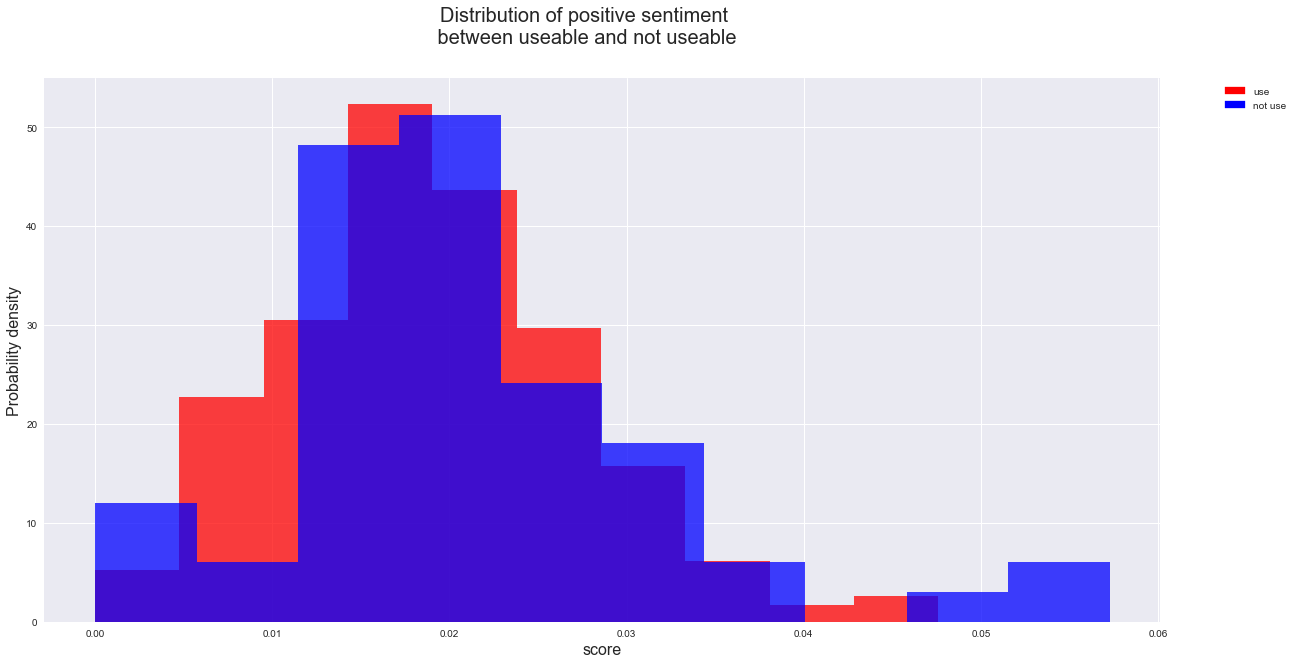

               T         dof       tail    p-val         CI95%   cohen-d  \
T-test -2.229028  318.182616  two-sided  0.02651  [-0.0, -0.0]  0.230119   

         BF10     power  
T-test  1.201  0.636034  


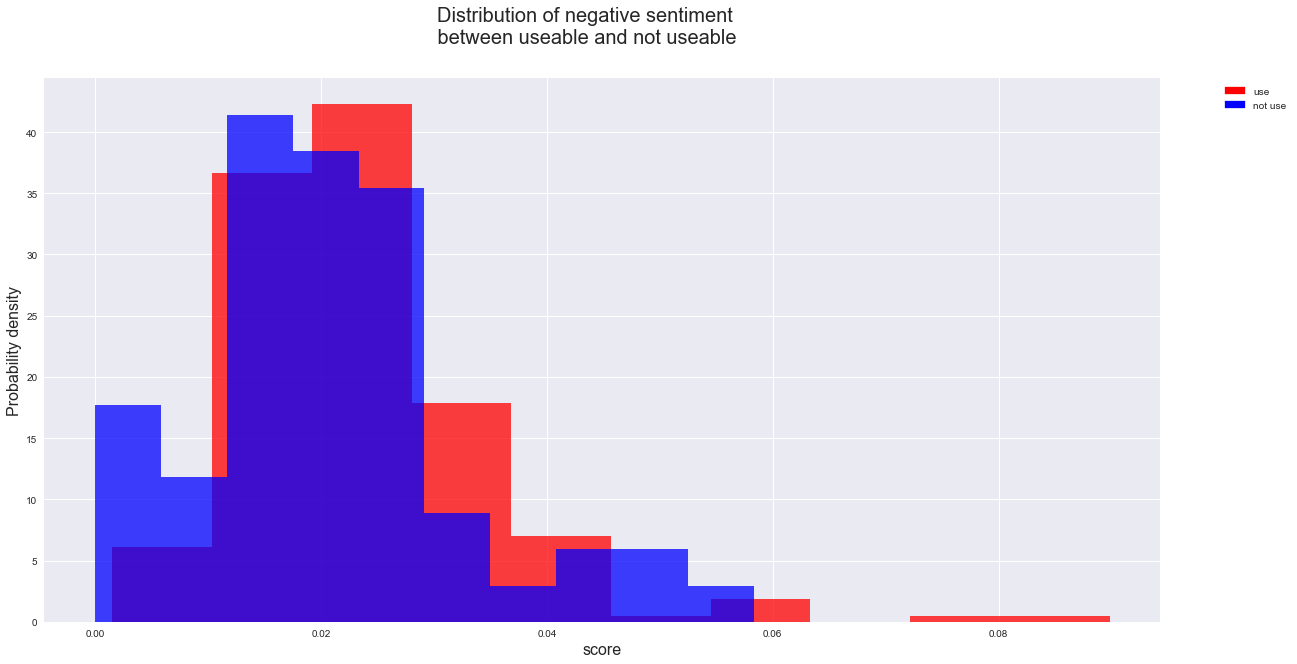

               T         dof       tail     p-val       CI95%  cohen-d   BF10  \
T-test  2.183616  352.823341  two-sided  0.029649  [0.0, 0.0]  0.22032  1.091   

           power  
T-test  0.598556  


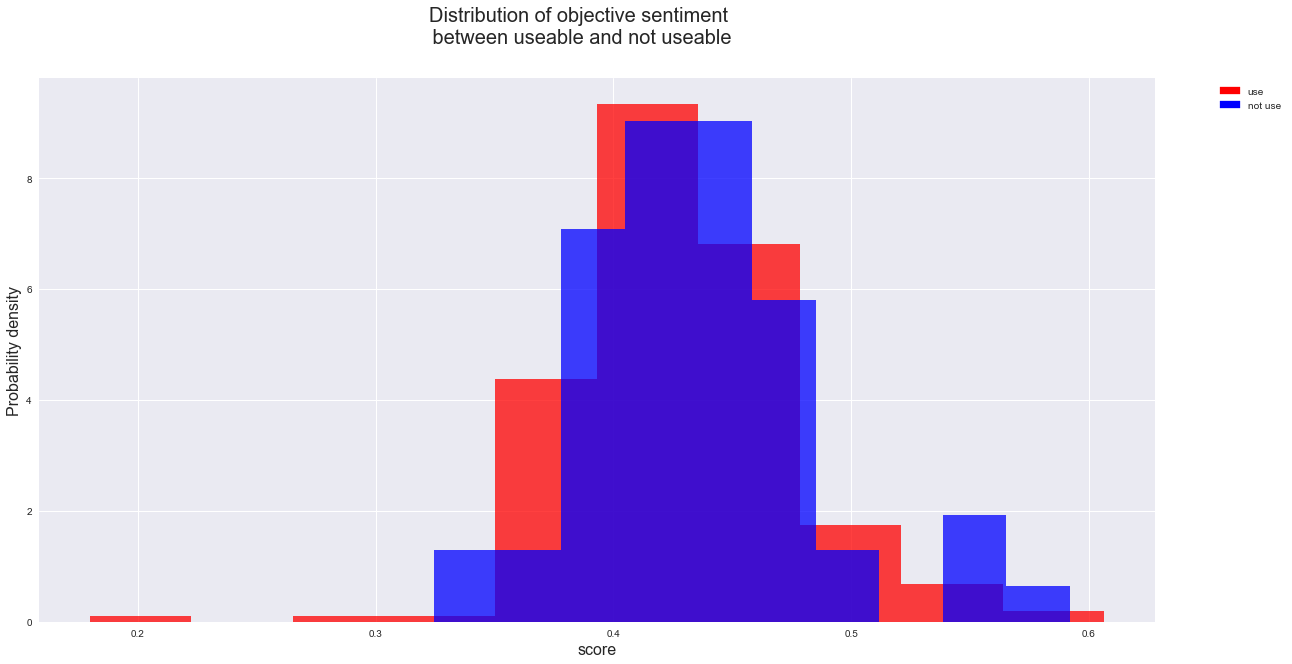

               T         dof       tail     p-val         CI95%   cohen-d  \
T-test -1.789883  352.312816  two-sided  0.074331  [-0.02, 0.0]  0.180656   

         BF10     power  
T-test  0.515  0.441171  


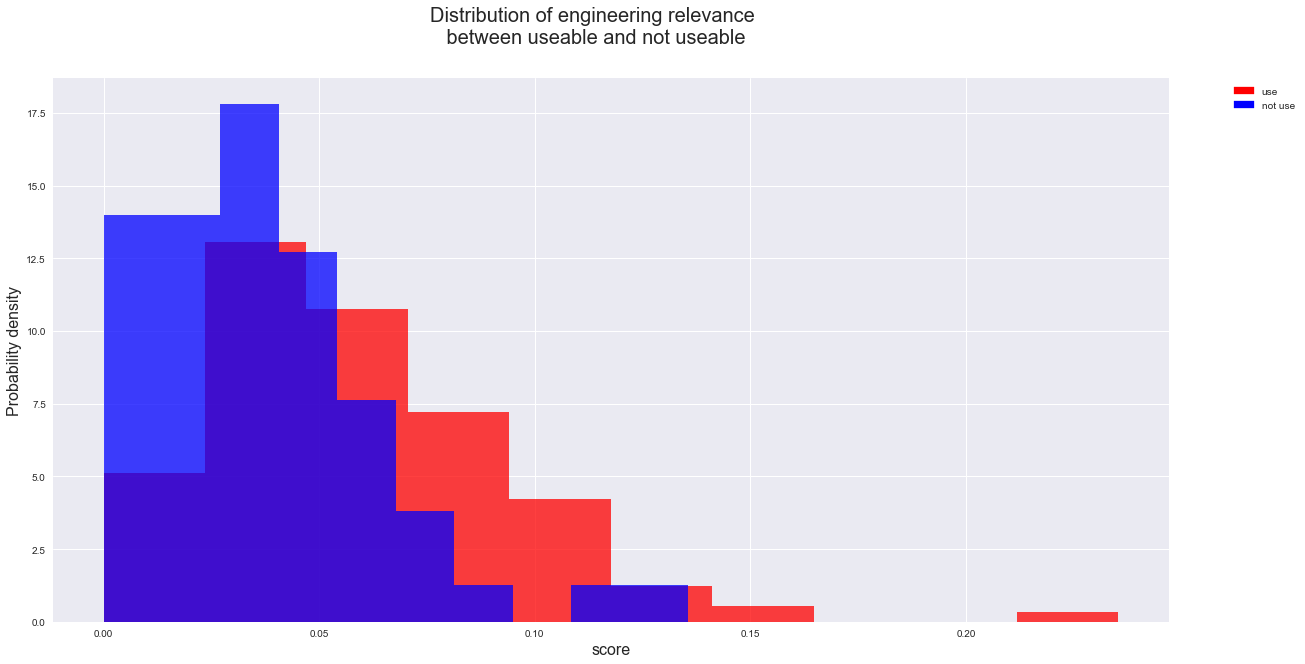

              T         dof       tail         p-val         CI95%   cohen-d  \
T-test  7.22831  411.053477  two-sided  2.400762e-12  [0.02, 0.03]  0.690339   

             BF10  power  
T-test  2.852e+09    1.0  


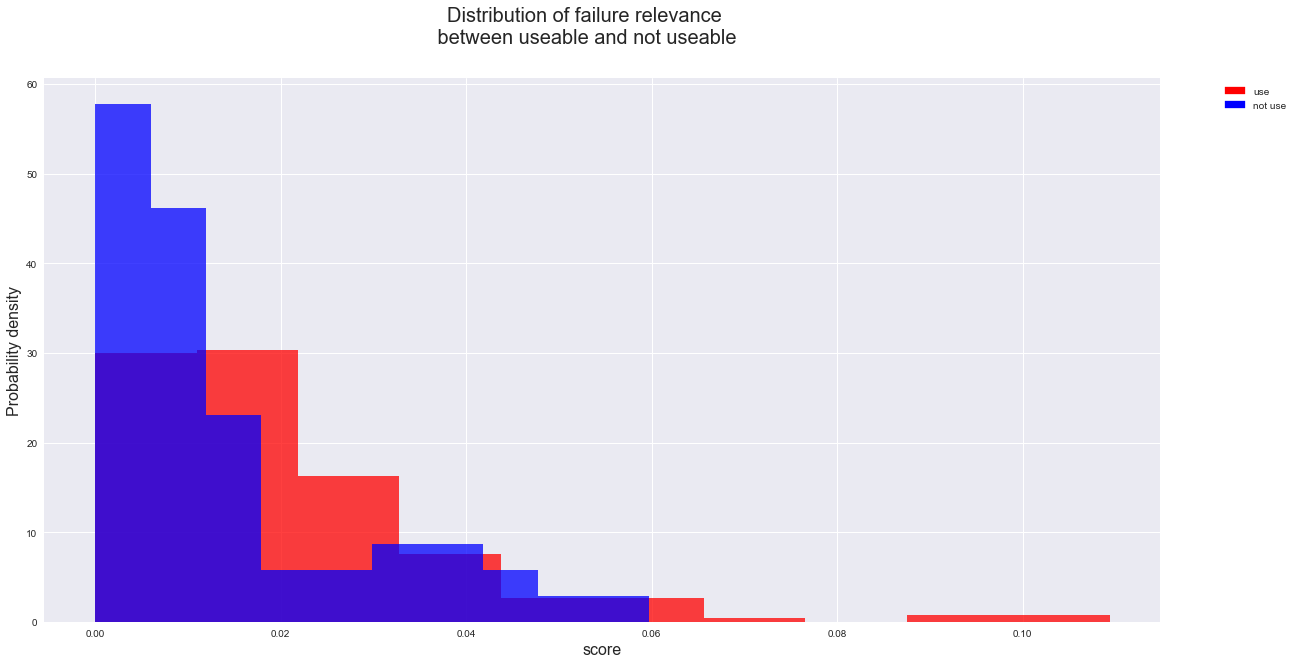

               T         dof       tail     p-val        CI95%   cohen-d  \
T-test  4.162108  403.386134  two-sided  0.000039  [0.0, 0.01]  0.402744   

           BF10     power  
T-test  412.827  0.981193  


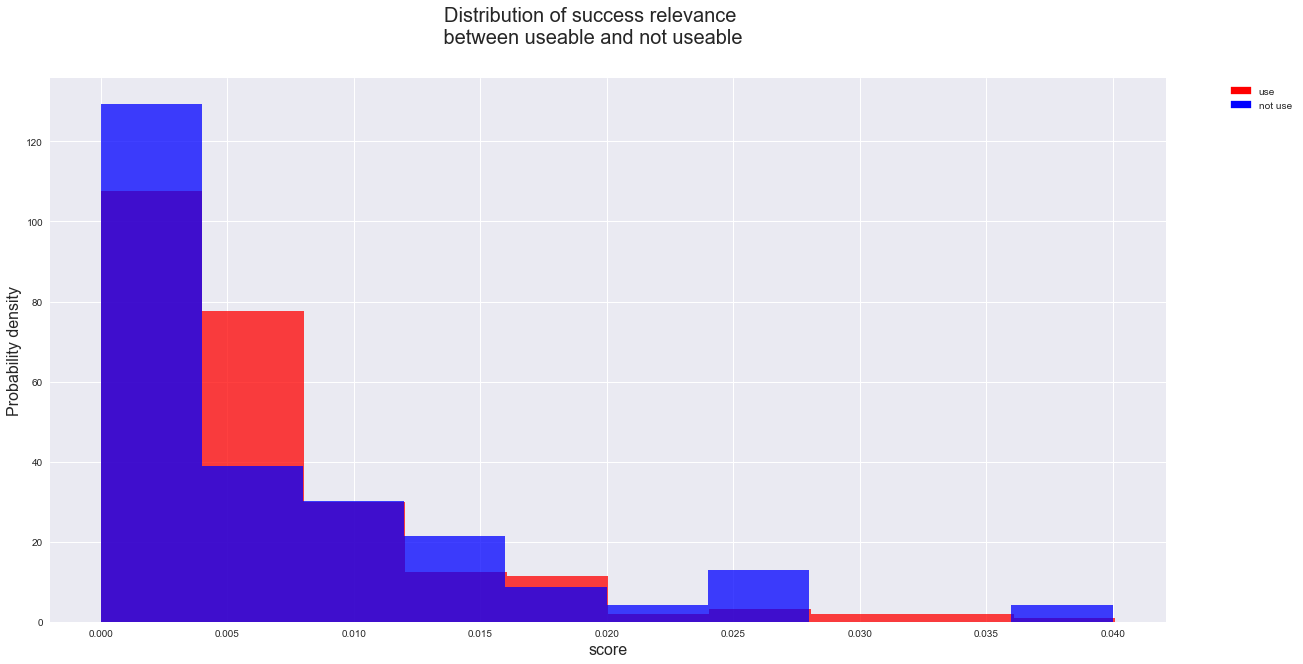

               T        dof       tail     p-val        CI95%  cohen-d   BF10  \
T-test -0.617355  326.89369  two-sided  0.537431  [-0.0, 0.0]  0.06337  0.132   

           power  
T-test  0.097401  


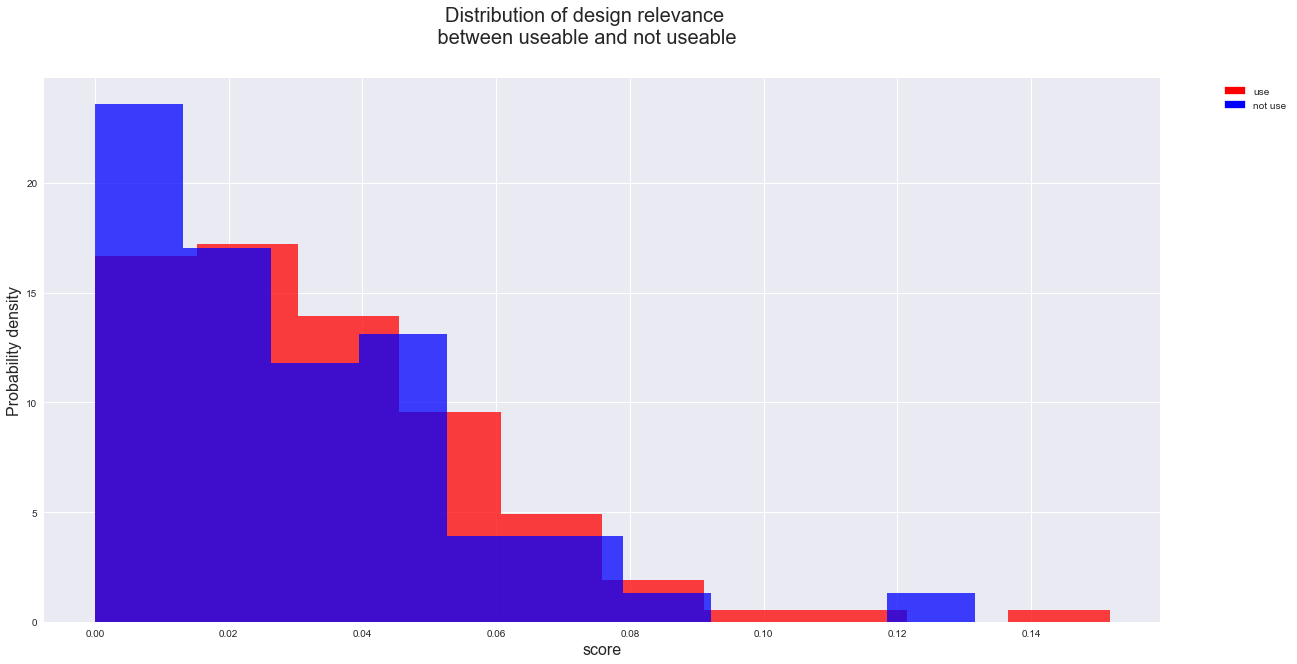

               T         dof       tail     p-val         CI95%   cohen-d  \
T-test  1.622821  365.738815  two-sided  0.105489  [-0.0, 0.01]  0.162279   

         BF10     power  
T-test  0.392  0.369923  


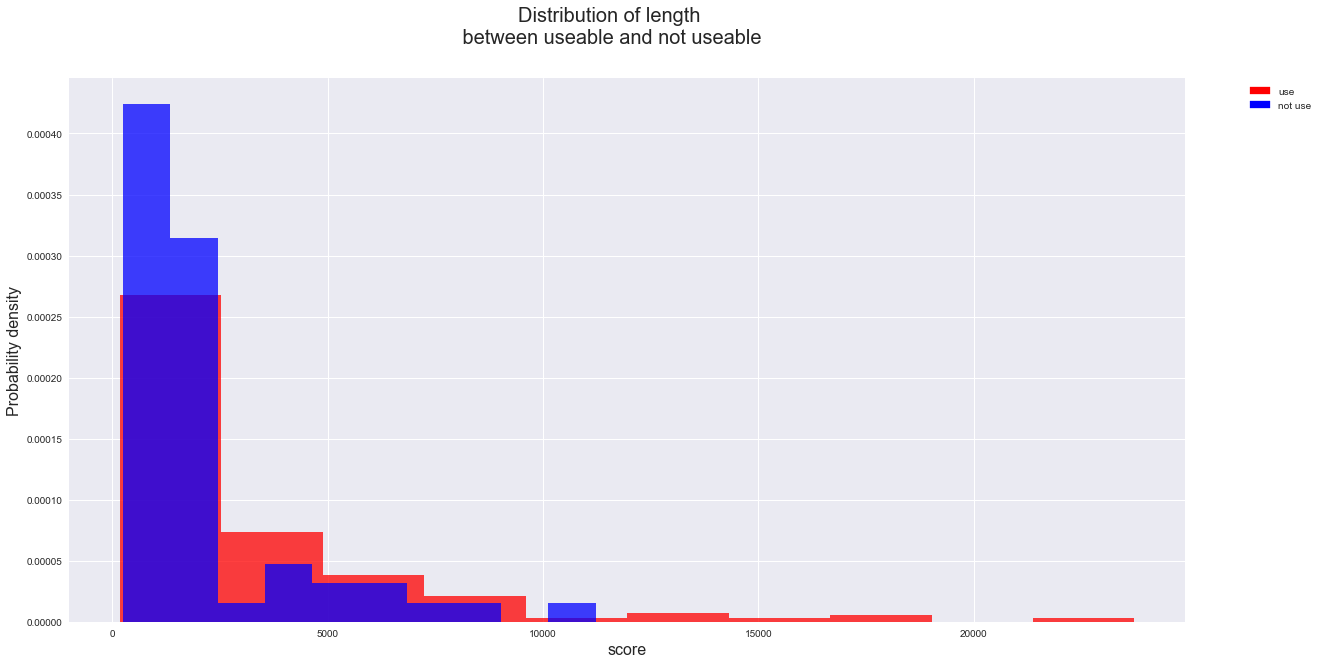

               T         dof       tail     p-val             CI95%   cohen-d  \
T-test  3.620829  397.487223  two-sided  0.000332  [490.0, 1654.22]  0.332675   

          BF10     power  
T-test  57.267  0.915643  


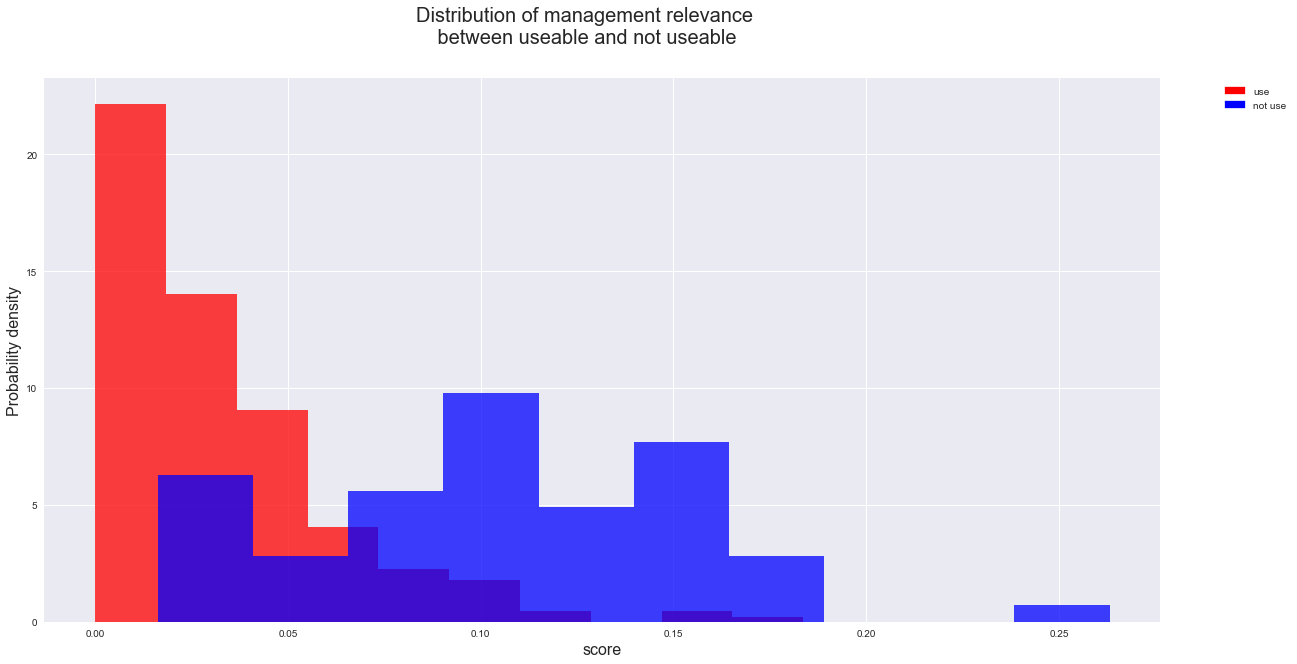

                T         dof       tail         p-val           CI95%  \
T-test -17.058732  261.977715  two-sided  2.147049e-44  [-0.08, -0.06]   

         cohen-d       BF10  power  
T-test  1.831456  1.479e+46    1.0  


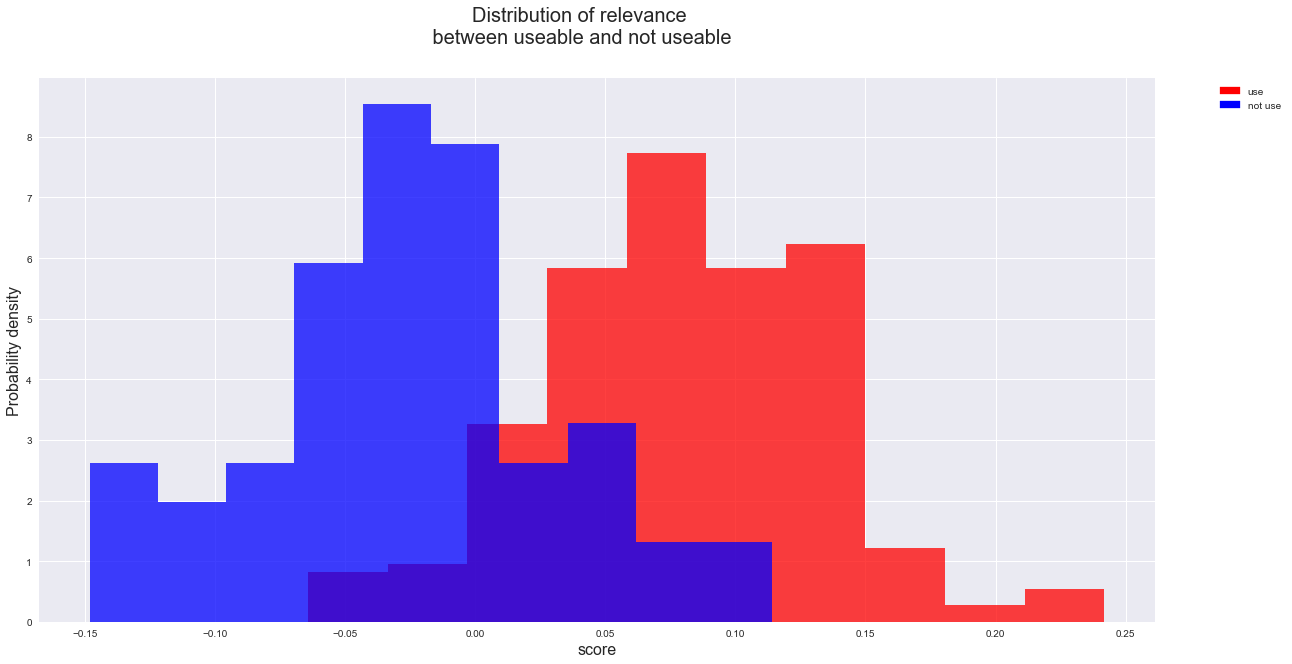

                T         dof       tail         p-val         CI95%  \
T-test  18.911317  358.843615  two-sided  7.825939e-56  [0.09, 0.12]   

         cohen-d       BF10  power  
T-test  1.900254  1.669e+54    1.0  


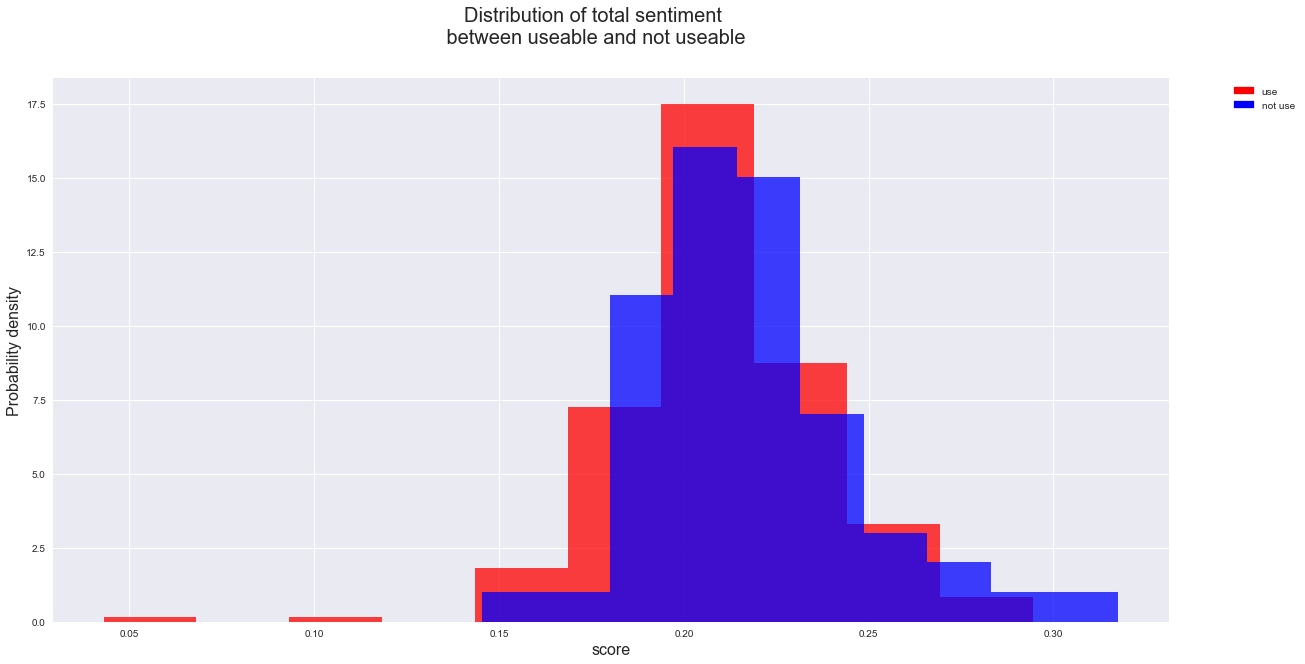

               T         dof       tail     p-val          CI95%   cohen-d  \
T-test -3.149505  360.827251  two-sided  0.001772  [-0.01, -0.0]  0.316035   

          BF10     power  
T-test  12.685  0.886759  


In [14]:
import pingouin as pg
for score in use_scores:
    
    fig = plt.figure(figsize= (20, 10))
    ax = fig.add_subplot(111)

    p_d1= plt.hist(use_scores[score], label= "use",density= True, alpha=0.75, color = 'red')
    p_d2 = plt.hist(not_use_scores[score], label= "not use",density= True, alpha=0.75, color = 'blue')
    title = 'Distribution of ' + str(score)+'\n between useable and not useable' 
    plt.suptitle(title, fontsize= 20)
    plt.xlabel("score", fontsize= 16)
    plt.ylabel("Probability density", fontsize= 16)
    label1 = patches.Patch(color = 'red', label = "use")
    label2 = patches.Patch(color = 'blue', label = "not use")
    plt.legend(handles = [label1, label2], bbox_to_anchor=(1.05, 1.0), loc='upper left')

    plt.show()
    print(pg.ttest(use_scores[score], not_use_scores[score], paired = False))

### Factors exploration
the following cells train/test the random forest model on varying numbers of factors to determine which combination is best

In [12]:
model = RandomForestClassifier(n_estimators=200,max_depth=4, random_state=0)
feature_list = [["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"],
               ["engineering relevance","failure relevance", "management relevance"],
               ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance",
               "relevance", "total sentiment"],
               ["total sentiment","relevance", "failure relevance", "management relevance","length"],
                ["engineering relevance","failure relevance","success relevance","design relevance", 
                 "length", "management relevance"]
               ]
test_acc = []; train_acc = []; conf_mat = [];false_pos = [];false_neg = [];precision = [];recall = [];f1 = []
for features in feature_list:
    X = df_test_set_with_scores[features]
    y = df_test_set_with_scores['use']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(accuracy_score(y_train.astype(int), model.predict(X_train.astype(float))))
    test_acc.append(accuracy_score(y_test.astype(int), model.predict(X_test.astype(float))))
    pos, neg = find_errors(X_test, y_test.astype(int), model,df_test_set_with_scores)
    false_pos.append(pos); false_neg.append(neg)
    f1.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average="macro"))
    precision.append(precision_score(y_test.astype(int), model.predict(X_test.astype(float)),average="macro"))
    recall.append(recall_score(y_test.astype(int), model.predict(X_test.astype(float)), average="macro"))

results = pd.DataFrame({
        "train accuracy": train_acc,
        "test accuracy":test_acc,
        "recall score": recall,
        "precision score": precision,
        "f1 score": f1,
        "confusion matrix":conf_mat,
        "false positives": false_pos,
        "false negatives": false_neg
    })
display(results)


,train accuracy,test accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,0.924686,0.883333,0.758592,0.879808,0.797980,"[[7, 6], [1, 46]]","[18201, 21101, 1138, 1181, 1806, 4770]",[1296]
1,0.916318,0.883333,0.758592,0.879808,0.797980,"[[7, 6], [1, 46]]","[18201, 21101, 1138, 1181, 1806, 4770]",[1296]
2,0.933054,0.850000,0.737316,0.790000,0.757956,"[[7, 6], [3, 44]]","[18201, 21101, 1138, 1181, 1806, 4770]","[3556, 1469, 1296]"
3,0.937238,0.850000,0.737316,0.790000,0.757956,"[[7, 6], [3, 44]]","[18201, 21101, 1138, 1181, 1806, 4770]","[3556, 1469, 1296]"
4,0.924686,0.883333,0.758592,0.879808,0.797980,"[[7, 6], [1, 46]]","[18201, 21101, 1138, 1181, 1806, 4770]",[1296]


## Machine Learning Model 1 for Classification
A collection of models are hyper parameter tuned, then used for classifying each document as useable or not. The performance of the models are compared to determine which model is the best. First each model is tuned using the training and test set. Final performance is tested on a separate validation set. Minmax scaling is performed to normalize the input data.

In [12]:
def normalize_data(train, valid, test, features, flag='minmax'):  
    num_features = np.shape(train)[1]
    if flag == 'standard':
        mean_vec = np.zeros(num_features)
        std_vec = np.zeros(num_features)
        
        for i in range(num_features):
            mean_vec[i] = np.mean(train[:, :, i])
            std_vec[i] = np.std(train[:, :, i])

        train_norm = np.zeros(np.shape(train))
        valid_norm = np.zeros(np.shape(valid))
        test_norm = np.zeros(np.shape(test))
        
        for j in range(num_features):
            if std_vec[j] == 0:
                train_norm[:, :, j] = 0
                valid_norm[:, :, j] = 0
                test_norm[:, :, j] = 0
            else:
                for i in range(np.shape(train)[0]):
                    train_norm[i, :, j] = (train[i, :, j] - mean_vec[j]) / std_vec[j]

                for i in range(np.shape(valid)[0]):
                    valid_norm[i, :, j] = (valid[i, :, j] - mean_vec[j]) / std_vec[j]

                for i in range(np.shape(test)[0]):
                    test_norm[i, :, j] = (test[i, :, j] - mean_vec[j]) / std_vec[j]

                
    elif flag == 'minmax':
        
        max_vec = np.zeros(num_features)
        min_vec = np.zeros(num_features)
        
        for i in range(num_features):
            max_vec[i] = np.max(train.iloc[:][features[i]])
            min_vec[i] = np.min(train.iloc[:][features[i]])

        train_norm = np.zeros(np.shape(train))
        valid_norm = np.zeros(np.shape(valid))
        test_norm = np.zeros(np.shape(test))
        
        #print(max_vec)
        #print(min_vec)
        for j in range(num_features):
            if (max_vec[j] - min_vec[j]) == 0:
                train_norm[:, j] = 0
                valid_norm[:, j] = 0
                test_norm[:, j] = 0
            else:
                for i in range(np.shape(train)[0]):
                    #print(train_norm[i, j])
                    #print(features[j])
                    #print(train.iloc[i][features[j]])
                    #print(train.at[i, features[j]])
                    train_norm[i, j] = (train.iloc[i][features[j]] - min_vec[j]) / (max_vec[j] - min_vec[j])
                for i in range(np.shape(valid)[0]):
                    valid_norm[i, j] = (valid.iloc[i][features[j]] - min_vec[j]) / (max_vec[j] - min_vec[j])
                for i in range(np.shape(test)[0]):
                    test_norm[i, j] = (test.iloc[i][features[j]] - min_vec[j]) / (max_vec[j] - min_vec[j])
    train_norm = pd.DataFrame(data=train_norm, columns=features)
    valid_norm = pd.DataFrame(data=valid_norm, columns=features)
    test_norm = pd.DataFrame(data=test_norm, columns=features)
    return train_norm, valid_norm, test_norm

In [13]:
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
            "failure relevance","success relevance","design relevance", "length", "management relevance"]

X_valid_not_scaled = validation_df_with_scores[features]
y_valid = validation_df_with_scores['use']
X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use']
X_train_not_scaled, X_test_not_scaled, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train, X_valid, X_test = normalize_data(X_train_not_scaled, X_valid_not_scaled, X_test_not_scaled, flag='minmax', features=features)

### Naive Bayes hyper parameter tuning

In [14]:
train_acc = []
test_acc = []
conf_mat = []
model = GaussianNB()
model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})
display(model_comparisons)

,train f1,test f1,confusion matrix
0,0.788121,0.803601,"[[9, 4], [4, 43]]"


In [15]:
naive_bayes_model = GaussianNB()

summary: there are no hyper parameters to tune for the naive bayes model

### Logistic Regression hyper parameter tuning

In [16]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_acc = []
test_acc = []
conf_mat = []
for solver in solvers:
    model = LogisticRegression(solver=solver, class_weight="balanced")
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "solver": solvers,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,solver,train f1,test f1,confusion matrix
0,newton-cg,0.811067,0.880526,"[[11, 2], [3, 44]]"
1,lbfgs,0.811067,0.880526,"[[11, 2], [3, 44]]"
2,liblinear,0.811067,0.880526,"[[11, 2], [3, 44]]"
3,sag,0.811067,0.880526,"[[11, 2], [3, 44]]"
4,saga,0.811067,0.880526,"[[11, 2], [3, 44]]"


In [17]:
classweights = ["balanced", None]
train_acc = []
test_acc = []
conf_mat = []
for weight in classweights:
    model = LogisticRegression(class_weight=weight)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "class weight": classweights,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,class weight,train f1,test f1,confusion matrix
0,balanced,0.811067,0.880526,"[[11, 2], [3, 44]]"
1,None,0.661624,0.514825,"[[1, 12], [0, 47]]"


In [19]:
solver = 'liblinear'
c_vals = np.arange(0.1, 3.1, 0.1)
train_acc = []
test_acc = []
conf_mat = []
for i in range(len(c_vals)):
    model = LogisticRegression(solver="liblinear", C=c_vals[i], class_weight="balanced")
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "C value": c_vals,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})
print("best c value:", c_vals[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])
#model_comparisons

best c value: 0.1
train f1: 0.7926547137073453
test f1: 0.8805256869772998


In [48]:
logistic_model = LogisticRegression(solver='liblinear', C=0.1, class_weight="balanced")

Summary: hyper parameter tuning on solvers, classweight, and c values does improve performance for the logistic model, specifically for classifying the minority class

### SVC hyper parameter tuning

In [20]:
kernals = ['linear', 'poly', 'rbf', 'sigmoid']
train_acc = []
test_acc = []
conf_mat = []
for kernal in kernals:
    model = svm.SVC(kernel=kernal, class_weight="balanced")
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "kernels": kernals,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,kernels,train f1,test f1,confusion matrix
0,linear,0.820571,0.852700,"[[10, 3], [3, 44]]"
1,poly,0.905849,0.772632,"[[8, 5], [4, 43]]"
2,rbf,0.856456,0.777778,"[[10, 3], [7, 40]]"
3,sigmoid,0.647902,0.603175,"[[8, 5], [15, 32]]"


In [21]:
c_vals = np.arange(0.1, 3.1, 0.1)
train_acc = []
test_acc = []
conf_mat = []
for c in c_vals:
    model = svm.SVC(kernel="linear", class_weight="balanced", C=c)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "c values": c_vals,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

#model_comparisons
print("best c value:", c_vals[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best c value: 0.1
train f1: 0.7881205673758864
test f1: 0.8527004909983633


In [49]:
SVC_model = svm.SVC(kernel="linear", class_weight="balanced")

summary: the SVC model has the best performance with a linear kernel

### K nearest neighbors hyper parameter tuning

In [22]:
algorithms = ['auto', 'ball_tree', 'kd_tree', 'brute']
weights = ['uniform', 'distance']
neighbors = np.arange(1, 50, 1)

In [23]:
#KNeighborsClassifier(n_neighbors=10, weights = 'distance')
train_acc = []
test_acc = []
conf_mat = []
for alg in algorithms:
    model = KNeighborsClassifier(n_neighbors=8, algorithm=alg)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "algorithms": algorithms,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,algorithms,train f1,test f1,confusion matrix
0,auto,0.814193,0.76,"[[6, 7], [1, 46]]"
1,ball_tree,0.814193,0.76,"[[6, 7], [1, 46]]"
2,kd_tree,0.814193,0.76,"[[6, 7], [1, 46]]"
3,brute,0.814193,0.76,"[[6, 7], [1, 46]]"


In [24]:
train_acc = []
test_acc = []
conf_mat = []
for weight in weights:
    model = KNeighborsClassifier(n_neighbors=8, weights=weight)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "weights": weights,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons

,weights,train f1,test f1,confusion matrix
0,uniform,0.814193,0.760000,"[[6, 7], [1, 46]]"
1,distance,1.000000,0.718603,"[[5, 8], [1, 46]]"


In [25]:
train_acc = []
test_acc = []
conf_mat = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "neighbors": neighbors,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", neighbors[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best n value: 8
train f1: 0.8141928662499611
test f1: 0.76


In [26]:
knearest_model = KNeighborsClassifier(n_neighbors=8)

summary: hyperparameter tuning showed that only the number of neighbors improves the model, with 8 being the best option

### AdaBoost hyper parameter tuning

In [27]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,300,5)

In [28]:
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    model =AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth,class_weight='balanced'),n_estimators=200)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "depth": depths,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best depth value:", depths[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best depth value: 8
train f1: 1.0
test f1: 0.7916666666666667


In [32]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42),n_estimators=n)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", n_estimators[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best n value: 180
train f1: 1.0
test f1: 0.8437500000000001


In [36]:
adaboost_model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42),n_estimators=180)

### xgBoost hyper parameter tuning

In [34]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,300,5)

In [35]:
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    model = xgb.XGBClassifier(max_depth = depth, n_estimators = 200)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "depth": depths,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best depth value:", depths[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("testf1:",  test_acc[np.argmax(test_acc)])

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:29:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best depth value: 4
train f1: 1.0
testf1: 0.797979797979798


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [37]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    model = xgb.XGBClassifier(max_depth = 4, n_estimators = n)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", n_estimators[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[10:30:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labe

In [38]:
xgboost_model = xgb.XGBClassifier(max_depth = 4, n_estimators = 25)

### Random Forest hyper parameter tuning

In [39]:
depths = np.arange(2,10,1)
n_estimators = np.arange(25,350,5)

In [40]:
train_acc = []
test_acc = []
conf_mat = []
for depth in depths:
    model = RandomForestClassifier(n_estimators=100,max_depth=depth, random_state=0, class_weight="balanced_subsample")
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "depth": depths,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best depth value:", depths[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best depth value: 2
train f1: 0.8556346350815454
test f1: 0.8736842105263158


In [44]:
train_acc = []
test_acc = []
conf_mat = []
for n in n_estimators:
    model = RandomForestClassifier(n_estimators=n, max_depth=3, random_state=0, class_weight="balanced_subsample")
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "n estimators": n_estimators,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})

model_comparisons
print("best n value:", n_estimators[np.argmax(test_acc)])
print("train f1:", train_acc[np.argmax(test_acc)])
print("test f1:",  test_acc[np.argmax(test_acc)])

best n value: 105
train f1: 0.9014703861481379
test f1: 0.8736842105263158


In [45]:
model = RandomForestClassifier(n_estimators=105, max_depth=3, random_state=0, class_weight="balanced_subsample")
model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
print(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
print(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
print(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

[[10  3]
 [ 2 45]]
0.9014703861481379
0.8736842105263158


In [56]:
RF_model = RandomForestClassifier(n_estimators=300,max_depth=4, random_state=0)#, class_weight="balanced_subsample")
#RandomForestClassifier(n_estimators=105, max_depth=3, random_state=0, class_weight="balanced_subsample")

## Model Comparison

### Single-Fold Cross-Validation
used for training and testing the model

In [58]:
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
            "failure relevance","success relevance","design relevance", "length", "management relevance"]
train_acc = []
test_acc = []
model_names = ["NB", "Logistic Regression", "SVC", "Random Forest",
              "AdaBoost", "XGBoost", "K nearest neighbors"]
models = [naive_bayes_model, logistic_model, SVC_model, RF_model, adaboost_model, xgboost_model, knearest_model]
conf_mat = []
for m in models:
    model = m
    X = df_test_set_with_scores[features]
    y = df_test_set_with_scores['use']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float)), average='macro'))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average='macro'))

model_comparisons = pd.DataFrame({
    "model":model_names,
    "train f1": train_acc,
    "test f1": test_acc,
    "confusion matrix": conf_mat
})
display(model_comparisons)

[10:47:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

,model,train f1,test f1,confusion matrix
0,NB,0.470813,0.439252,"[[0, 13], [0, 47]]"
1,Logistic Regression,0.470778,0.499846,"[[7, 6], [21, 26]]"
2,SVC,0.560496,0.607201,"[[5, 8], [8, 39]]"
3,Random Forest,0.865575,0.797980,"[[7, 6], [1, 46]]"
4,AdaBoost,1.000000,0.811744,"[[8, 5], [2, 45]]"
5,XGBoost,0.993214,0.797980,"[[7, 6], [1, 46]]"
6,K nearest neighbors,0.599367,0.405941,"[[0, 13], [6, 41]]"


### Stratified K-Fold Cross-Validation
used to train and test the data with k = 5
other values of k are also used, but k=5 seems to maximize test accuracy

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245

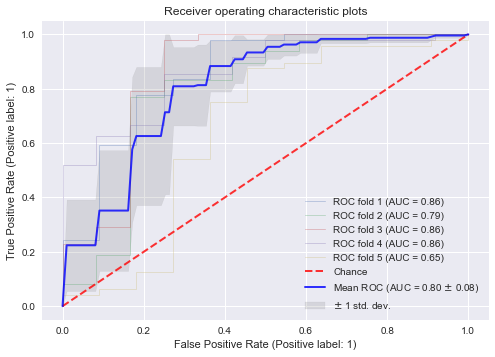

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.816667,0.500000,0.408333,0.449541,"[[0, 11], [0, 49]]","[4770, 1830, 1589, 1560, 852, 1524, 1503, 1440...",[]
1,2,0.800000,0.500000,0.400000,0.444444,"[[0, 12], [0, 48]]","[6138, 6016, 5976, 1806, 1455, 1421, 1292, 128...",[]
2,3,0.816667,0.541667,0.906780,0.525521,"[[1, 11], [0, 48]]","[21101, 18201, 7076, 5296, 4516, 1462, 1422, 1...",[]
3,4,0.800000,0.500000,0.400000,0.444444,"[[0, 12], [0, 48]]","[7136, 1555, 1552, 1337, 1271, 1140, 1075, 104...",[]
4,5,0.813559,0.500000,0.406780,0.448598,"[[0, 11], [0, 48]]","[6856, 6637, 1828, 1472, 1474, 1433, 1405, 125...",[]


,average accuracy,average f1,average precision,average recall
0,0.809379,0.46251,0.504379,0.508333


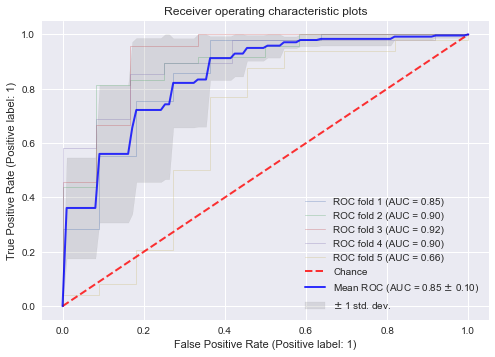

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.766667,0.751391,0.673941,0.688889,"[[8, 3], [11, 38]]","[852, 483, 480]","[4584, 3556, 1615, 1350, 1276, 1097, 1054, 105..."
1,2,0.833333,0.802083,0.747159,0.767081,"[[9, 3], [7, 41]]","[6138, 1806, 1292]","[6996, 5117, 5163, 4658, 1575, 1345, 1241]"
2,3,0.916667,0.885417,0.863339,0.873684,"[[10, 2], [3, 45]]","[21101, 5296]","[1469, 1363, 325]"
3,4,0.850000,0.843750,0.770862,0.795377,"[[10, 2], [7, 41]]","[741, 338]","[4936, 1348, 1296, 1203, 1093, 1019, 916]"
4,5,0.745763,0.703598,0.645664,0.657110,"[[7, 4], [11, 37]]","[6856, 6637, 1474, 1181]","[5199, 5057, 5203, 3377, 2596, 1614, 1349, 128..."


,average accuracy,average f1,average precision,average recall
0,0.822486,0.756428,0.740193,0.797248


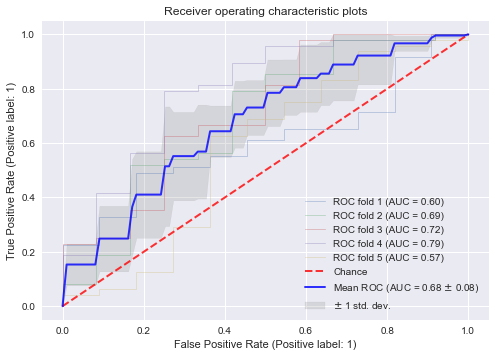

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.616667,0.553803,0.534689,0.519331,"[[5, 6], [17, 32]]","[4770, 1830, 852, 889, 483, 480]","[25503, 1918, 4036, 1350, 1276, 1162, 1097, 10..."
1,2,0.750000,0.687500,0.647743,0.658962,"[[7, 5], [10, 38]]","[6138, 6016, 1806, 1421, 973]","[5117, 1277, 1241, 1177, 1161, 1148, 570, 513,..."
2,3,0.666667,0.666667,0.611111,0.603175,"[[8, 4], [16, 32]]","[21101, 18201, 5296, 1381]","[5004, 5877, 2896, 1862, 1469, 1363, 902, 858,..."
3,4,0.783333,0.739583,0.688782,0.704433,"[[8, 4], [9, 39]]","[7136, 1555, 741, 338]","[1364, 1296, 1239, 1019, 551, 256, 253, 25, 49]"
4,5,0.372881,0.509470,0.507003,0.366328,"[[8, 3], [34, 14]]","[6856, 6637, 1474]","[24403, 6345, 5199, 5057, 5013, 5203, 4596, 33..."


,average accuracy,average f1,average precision,average recall
0,0.63791,0.570446,0.597866,0.631405


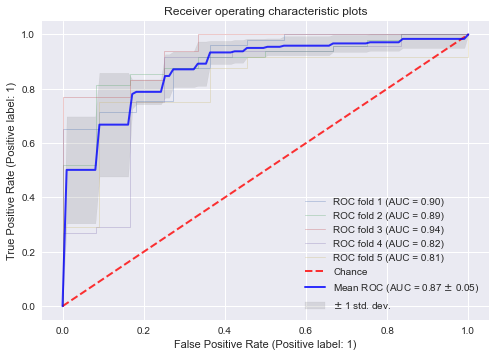

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.866667,0.777365,0.777365,0.777365,"[[7, 4], [4, 45]]","[4770, 852, 483, 480]","[3556, 1615, 1350, 896]"
1,2,0.850000,0.781250,0.765139,0.772632,"[[8, 4], [5, 43]]","[6138, 1292, 1136, 1102]","[7217, 6996, 5163, 1575, 1345]"
2,3,0.900000,0.812500,0.860000,0.833024,"[[8, 4], [2, 46]]","[21101, 5296, 1381, 977]","[1862, 1363]"
3,4,0.866667,0.822917,0.788820,0.803601,"[[9, 3], [5, 43]]","[1337, 741, 338]","[4936, 1348, 1296, 1093, 916]"
4,5,0.762712,0.714015,0.658263,0.672222,"[[7, 4], [10, 38]]","[1472, 1474, 1181, 943]","[5199, 5057, 6377, 5203, 3377, 2596, 1285, 116..."


,average accuracy,average f1,average precision,average recall
0,0.849209,0.771769,0.769918,0.781609


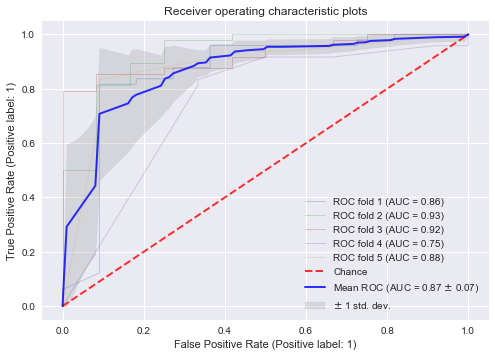

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.900000,0.797774,0.849673,0.820000,"[[7, 4], [2, 47]]","[4770, 852, 483, 480]","[1615, 1097]"
1,2,0.916667,0.822917,0.905229,0.855700,"[[8, 4], [1, 47]]","[6138, 1292, 1136, 1102]",[1148]
2,3,0.833333,0.614583,0.794643,0.639423,"[[3, 9], [1, 47]]","[21101, 18201, 5296, 4516, 1422, 1381, 1297, 9...",[1363]
3,4,0.833333,0.708333,0.740000,0.721707,"[[6, 6], [4, 44]]","[1552, 1337, 1271, 983, 741, 338]","[1348, 1296, 1019, 916]"
4,5,0.847458,0.871212,0.765583,0.794266,"[[10, 1], [8, 40]]",[1181],"[6377, 4596, 2596, 2044, 1168, 1123, 843, 120]"


,average accuracy,average f1,average precision,average recall
0,0.866158,0.766219,0.811025,0.762964


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

[15:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced d

[15:47:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


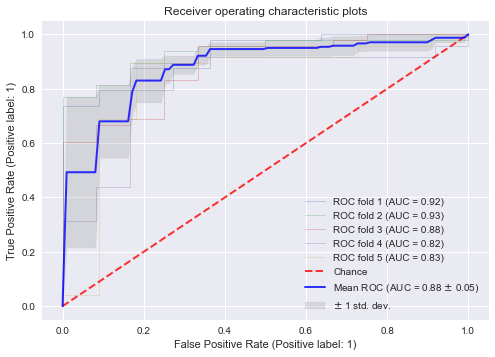

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.883333,0.787570,0.810000,0.797980,"[[7, 4], [3, 46]]","[4770, 852, 483, 480]","[1615, 1350, 1097]"
1,2,0.883333,0.833333,0.814239,0.823158,"[[9, 3], [4, 44]]","[1292, 1136, 1102]","[6996, 5163, 1345, 1241]"
2,3,0.833333,0.645833,0.759259,0.673203,"[[4, 8], [2, 46]]","[21101, 18201, 5296, 1381, 1297, 1064, 977, 919]","[902, 325]"
3,4,0.866667,0.791667,0.791667,0.791667,"[[8, 4], [4, 44]]","[7136, 1337, 741, 338]","[4936, 1348, 1296, 916]"
4,5,0.881356,0.857008,0.799206,0.822366,"[[9, 2], [5, 43]]","[1472, 1181]","[6377, 5203, 1285, 1168, 1123]"


,average accuracy,average f1,average precision,average recall
0,0.869605,0.781675,0.794874,0.783082


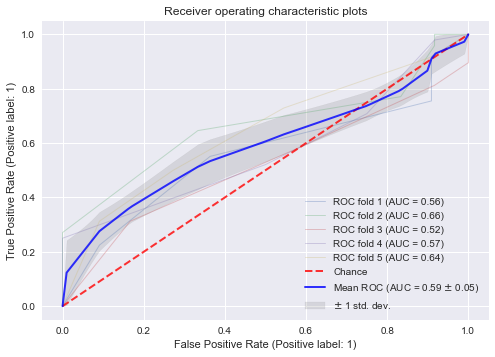

,fold,accuracy,recall score,precision score,f1 score,confusion matrix,false positives,false negatives
0,1,0.766667,0.504638,0.509091,0.495192,"[[1, 10], [4, 45]]","[4770, 1830, 1560, 852, 1524, 1503, 1440, 889,...","[3761, 1276, 1018, 57]"
1,2,0.783333,0.520833,0.570175,0.504762,"[[1, 11], [2, 46]]","[6016, 5976, 1806, 1455, 1421, 1292, 1287, 113...","[1241, 1161]"
2,3,0.716667,0.447917,0.390909,0.417476,"[[0, 12], [5, 43]]","[21101, 18201, 7076, 5296, 4516, 1462, 1422, 1...","[1469, 902, 313, 382, 389]"
3,4,0.800000,0.531250,0.655172,0.514825,"[[1, 11], [1, 47]]","[7136, 1555, 1552, 1337, 1271, 1140, 1075, 104...",[908]
4,5,0.762712,0.503788,0.507407,0.493873,"[[1, 10], [4, 44]]","[6856, 6637, 1472, 1474, 1433, 1405, 1251, 118...","[1273, 1247, 1123, 323]"


,average accuracy,average f1,average precision,average recall
0,0.765876,0.485225,0.526551,0.501685


,train 1,test 1,|,train 2,test 2,|,train 3,test 3,|,train 4,test 4,|,train 5,test 5,|
1.0,192,49,|,193,48,|,193,48,|,193,48,|,193,48,|
0.0,47,11,|,46,12,|,46,12,|,46,12,|,47,11,|


In [166]:
for m in models:
    model = m
    accuracies = []
    dfs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    folds = []
    conf_matrices = []
    false_pos = []
    false_neg = []
    precision = []
    recall = []
    f1 = []

    features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"]
    #features = ["total sentiment","relevance", "failure relevance", "management relevance","length"]

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    fig,ax=plt.subplots()
    j = 1
    for train_index, test_index in kf.split(df_test_set_with_scores,df_test_set_with_scores['use'].astype(int)):#, df_test_set_with_scores["use"]):
        X_train = df_test_set_with_scores.iloc[train_index].loc[:, features]
        X_test = df_test_set_with_scores.iloc[test_index].loc[:,features]
        y_train = df_test_set_with_scores.iloc[train_index].loc[:,'use']
        y_test = df_test_set_with_scores.loc[test_index].loc[:,'use']

        #Train the model and analyze results
        model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
        #print(f"Accuracy for the fold no. {j} on the test set: {accuracy_score(y_test.astype(int), model.predict(X_test.astype(float)))}, doublecheck: {model.score(X_test.astype(float),y_test.astype(int))}")
        accuracies.append(accuracy_score(y_test.astype(int), model.predict(X_test.astype(float))))
        #print("Confusion Matrix: ", confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
        conf_matrices.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
        folds.append(j)
        pos, neg = find_errors(X_test, y_test.astype(int), model,df_test_set_with_scores)
        false_pos.append(pos); false_neg.append(neg)
        f1.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float)), average="macro"))
        precision.append(precision_score(y_test.astype(int), model.predict(X_test.astype(float)),average="macro"))
        recall.append(recall_score(y_test.astype(int), model.predict(X_test.astype(float)), average="macro"))

        #plot ROC curves
        viz = plot_roc_curve(model, X_test.astype(float), y_test.astype(int),
                            name = 'ROC fold {}'.format(j), alpha = 0.3, lw = 1,
                            ax = ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # how many occurances appear in the train set
        s_train = df_test_set_with_scores.iloc[train_index].loc[:,'use'].value_counts()
        s_train.name = f"train {j}"
        s_test = df_test_set_with_scores.iloc[test_index].loc[:,'use'].value_counts()
        s_test.name = f"test {j}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        j += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic plots")
    ax.legend(loc="lower right")
    plt.show()


    results = pd.DataFrame({
        "fold":folds,
        "accuracy":accuracies,
        "recall score": recall,
        "precision score": precision,
        "f1 score": f1,
        "confusion matrix":conf_matrices,
        "false positives": false_pos,
        "false negatives": false_neg
    })
    display(results)

    recall_av = np.average(recall); acc_av= np.average(accuracies); f1_av= np.average(f1); prec_av = np.average(precision)
    av = pd.DataFrame({
        "average accuracy": [acc_av],
        "average f1": [f1_av],
        "average precision": [prec_av],
        "average recall": [recall_av]
    })

    display(av)

pd.concat(dfs,axis=1, sort=False)

### Validation Set 

In [17]:
df_validation = preprocessing(datasheet_path+"validation_set_final_H.csv")
#df_validation = df_test.drop("Unnamed: 33", axis = 1)
validation_df_with_scores, score_list = process_data(df_validation)
encode(validation_df_with_scores)
df_validation_target = validation_df_with_scores["use"] 
total_sentiment = []
for i in range(0, len(validation_df_with_scores)):
    sentiment = float(validation_df_with_scores.iloc[i]['positive sentiment']) - float(validation_df_with_scores.iloc[i]['negative sentiment'])+.5*float(validation_df_with_scores.iloc[i]['objective sentiment'])
    total_sentiment.append(sentiment)
validation_df_with_scores['total sentiment']= total_sentiment
total_relevance = []
for i in range(0, len(validation_df_with_scores)):
    relevance = float(validation_df_with_scores.iloc[i]['engineering relevance'])+float(validation_df_with_scores.iloc[i]['failure relevance'])+float(validation_df_with_scores.iloc[i]['design relevance'])-float(validation_df_with_scores.iloc[i]['management relevance'])
    total_relevance.append(relevance)
validation_df_with_scores['relevance']= total_relevance

In [59]:
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"]
train_acc = []; test_acc = []; train_recall = []; recall = []; false_pos = []; false_neg = []
precision = []; train_precision = []; train_f1 = []; f1 = [];
conf_mat = []; pos = []; neg = [];
X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use'].astype(int)
for model in models:
    model.fit(X,y)
    predicted_usability = model.predict(validation_df_with_scores.loc[:,features])
    conf_mat.append(confusion_matrix(df_validation_target.astype(int), predicted_usability))
    train_acc.append((accuracy_score(model.predict(X), y)))
    test_acc.append(accuracy_score(df_validation_target.astype(int), predicted_usability))
    pos, neg = find_errors(validation_df_with_scores.loc[:,features], df_validation_target.astype(int), model,validation_df_with_scores)
    false_pos.append(pos); false_neg.append(neg)
    train_f1.append(f1_score(y, model.predict(X), average="macro"))
    f1.append(f1_score(df_validation_target.astype(int), predicted_usability, average="macro"))
    precision.append(precision_score(df_validation_target.astype(int), predicted_usability, average="macro"))
    train_precision.append(precision_score(y, model.predict(X), average="macro"))
    recall.append(recall_score(df_validation_target.astype(int), predicted_usability, average="macro"))
    train_recall.append(recall_score(y, model.predict(X), average="macro"))

print(len(model_names), len(models), len(train_acc))
results = pd.DataFrame({
    "model": model_names,
    "train accuracy": train_acc,
    "test accuracy":test_acc,
    "train recall": train_recall,
    "test recall score": recall,
    "test precision score": precision,
    "train precision":train_precision,
    "train f1 score": train_f1,
    "test f1 score": f1,
    "confusion matrix":conf_mat,
    #"false positives": false_pos,
    #"false negatives": false_neg
    })
display(results)


C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[10:48:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
7 7 7


C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
C:\Users\srandrad\Anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (s

,model,train accuracy,test accuracy,train recall,test recall score,test precision score,train precision,train f1 score,test f1 score,confusion matrix
0,NB,0.809365,0.848485,0.508621,0.500000,0.424242,0.904362,0.464073,0.459016,"[[0, 15], [0, 84]]"
1,Logistic Regression,0.498328,0.515152,0.603699,0.604762,0.554545,0.568071,0.478003,0.469643,"[[11, 4], [44, 40]]"
2,SVC,0.685619,0.717172,0.602053,0.614286,0.574074,0.575837,0.577988,0.576923,"[[7, 8], [20, 64]]"
3,Random Forest,0.929766,0.919192,0.838604,0.815476,0.855546,0.929960,0.874913,0.833613,"[[10, 5], [3, 81]]"
4,AdaBoost,1.000000,0.828283,1.000000,0.707143,0.679012,1.000000,1.000000,0.690909,"[[8, 7], [10, 74]]"
5,XGBoost,1.000000,0.858586,1.000000,0.752381,0.728121,1.000000,1.000000,0.739081,"[[9, 6], [8, 76]]"
6,K nearest neighbors,0.799331,0.777778,0.548219,0.458333,0.418478,0.633254,0.547792,0.437500,"[[0, 15], [7, 77]]"


In [178]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
features = ["positive sentiment", "negative sentiment","objective sentiment","engineering relevance",
                "failure relevance","success relevance","design relevance", "length", "management relevance"]

#model = RandomForestClassifier(n_estimators=105, max_depth=3, random_state=0)#, class_weight="balanced_subsample")
model = RandomForestClassifier(n_estimators=250,max_depth=4, random_state=0)
X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use'].astype(int)
over = SMOTE()
X,y = over.fit_resample(X,y)
model.fit(X,y)
predicted_usability = model.predict(validation_df_with_scores.loc[:,features])
conf_mat = confusion_matrix(df_validation_target.astype(int), predicted_usability)
train_acc = (accuracy_score(model.predict(X), y))
test_acc = accuracy_score(df_validation_target.astype(int), predicted_usability)
pos, neg = find_errors(validation_df_with_scores.loc[:,features], df_validation_target.astype(int), model,validation_df_with_scores)
false_pos = pos; false_neg = neg
train_f1 = f1_score(y, model.predict(X), average="macro")
f1 = f1_score(df_validation_target.astype(int), predicted_usability, average="macro")
precision = precision_score(df_validation_target.astype(int), predicted_usability, average="macro")
train_precision = precision_score(y, model.predict(X), average="macro")
recall = recall_score(df_validation_target.astype(int), predicted_usability, average="macro")
train_recall = recall_score(y, model.predict(X), average="macro")

results = pd.DataFrame({
        "train accuracy": [train_acc],
        "test accuracy":[test_acc],
        "train recall": [train_recall],
        "test recall score": [recall],
        "test precision score": [precision],
        "train precision":[train_precision],
        "train f1 score": [train_f1],
        "test f1 score": [f1],
        "confusion matrix":[conf_mat],
        "false positives": [false_pos],
        "false negatives": [false_neg]
    })
display(results)

print(classification_report(validation_df_with_scores['use'].astype(int), predicted_usability.astype(int)))

,train accuracy,test accuracy,train recall,test recall score,test precision score,train precision,train f1 score,test f1 score,confusion matrix,false positives,false negatives
0,0.921162,0.828283,0.921162,0.871429,0.726087,0.923026,0.921075,0.755556,"[[14, 1], [16, 68]]",[1451],"[17802, 6756, 4588, 1592, 1780, 920, 1518, 147..."


              precision    recall  f1-score   support

           0       0.47      0.93      0.62        15
           1       0.99      0.81      0.89        84

    accuracy                           0.83        99
   macro avg       0.73      0.87      0.76        99
weighted avg       0.91      0.83      0.85        99



### Visualization

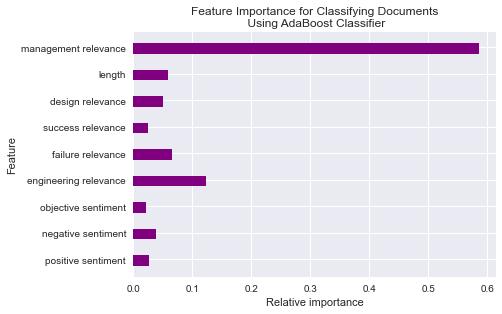

<Figure size 360x360 with 0 Axes>

In [22]:
y = model.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color="purple")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(features, minor=False)
plt.title('Feature Importance for Classifying Documents\n Using AdaBoost Classifier')
plt.xlabel('Relative importance')
plt.ylabel('Feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

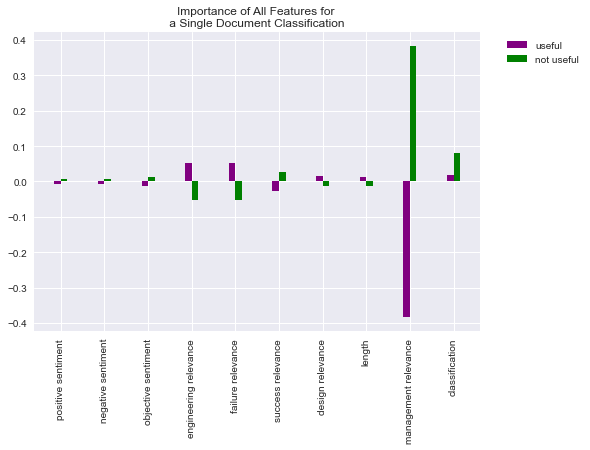

In [23]:
prediction, bias, contributions = ti.predict(model, X_test[8:9])
N = 10 # no of entries in plot , 4 ---> features & 1 ---- class label
use = []
not_use = []
for j in range(2):
    list_ =  [use , not_use]
    for i in range(9):
        val = contributions[0,i,j]
        list_[j].append(val)
#print(use, not_use)
use.append(prediction[0,0]/10)
not_use.append(prediction[0,1]/10)
#print(use, not_use)
fig, ax = plt.subplots()
ind = np.arange(N)   
width = 0.15        
p1 = ax.bar(ind, use, width, color='purple', bottom=0)
p2 = ax.bar(ind+width, not_use, width, color='green', bottom=0)
#p3 = ax.bar(ind+ (2*width), virginica, width, color='yellow', bottom=0)
ax.set_title('Importance of All Features for \n a Single Document Classification ')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(features+['classification'], rotation = 90)
ax.legend((p1[0], p2[0]), ('useful', 'not useful') , bbox_to_anchor=(1.04,1), loc="upper left")
ax.autoscale_view()
plt.show()

In [ ]:
model = RandomForestClassifier(n_estimators=240,max_depth=4, random_state=0)
X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
model.fit(X_train.astype(float), y_train.astype(int))
ax = plt.gca()
model_disp = plot_roc_curve(model, X_test.astype(float), y_test.astype(int), ax=ax, alpha=0.8)
plt.title("Receiver Operating Characteristic (ROC) Plot")
plt.show()

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


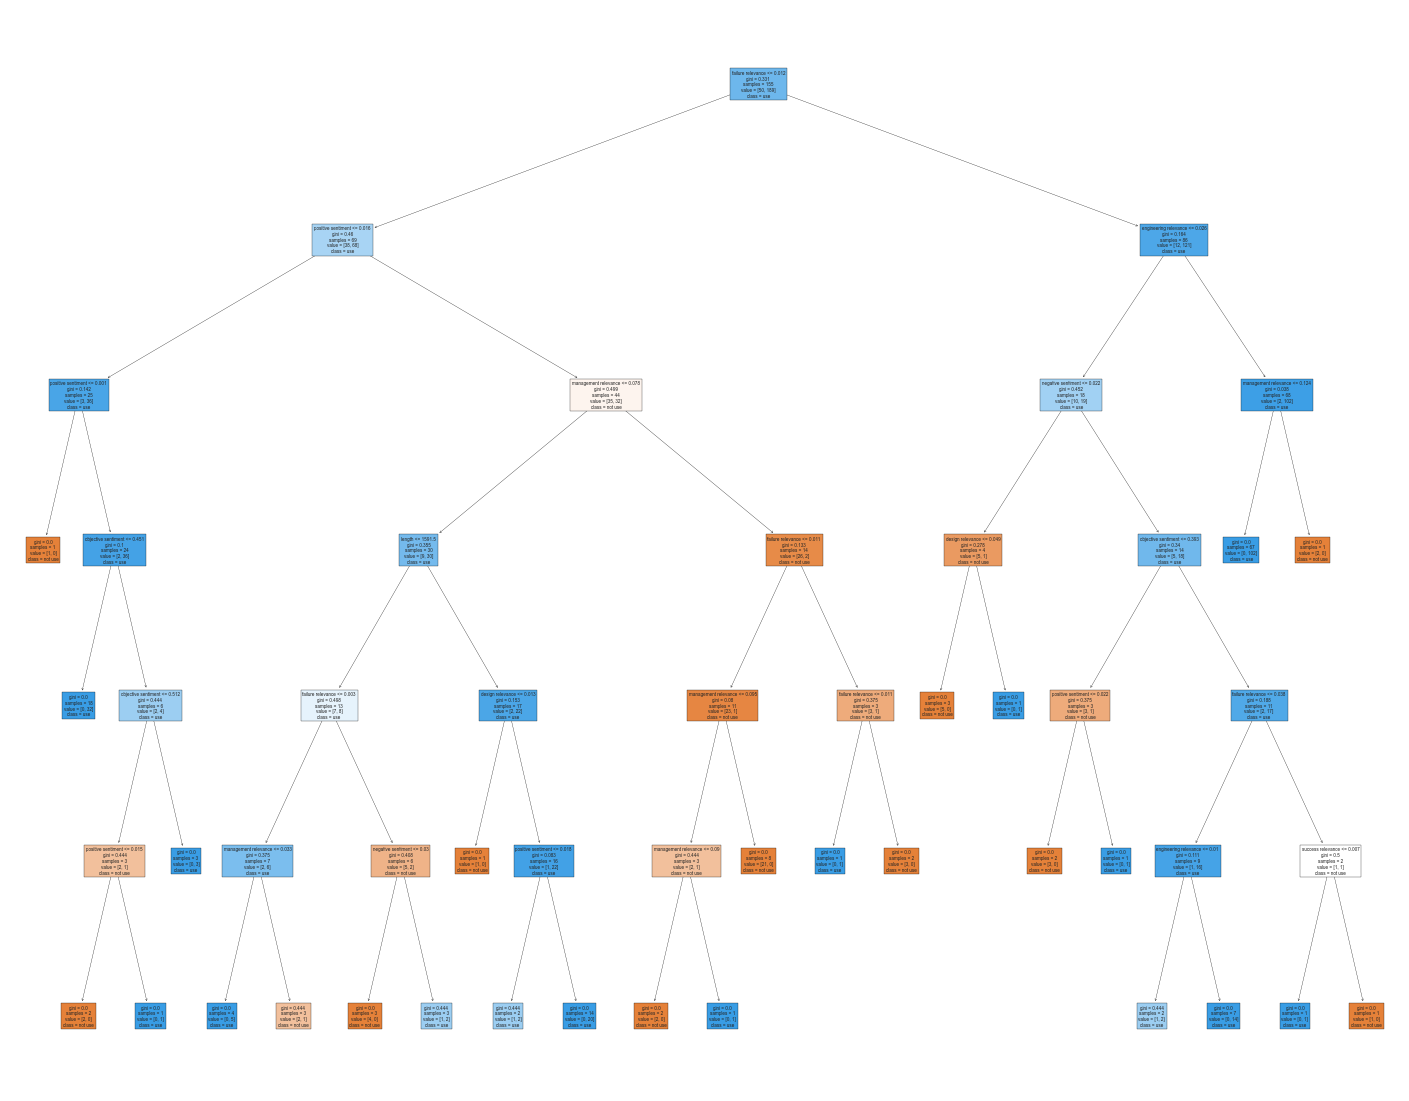

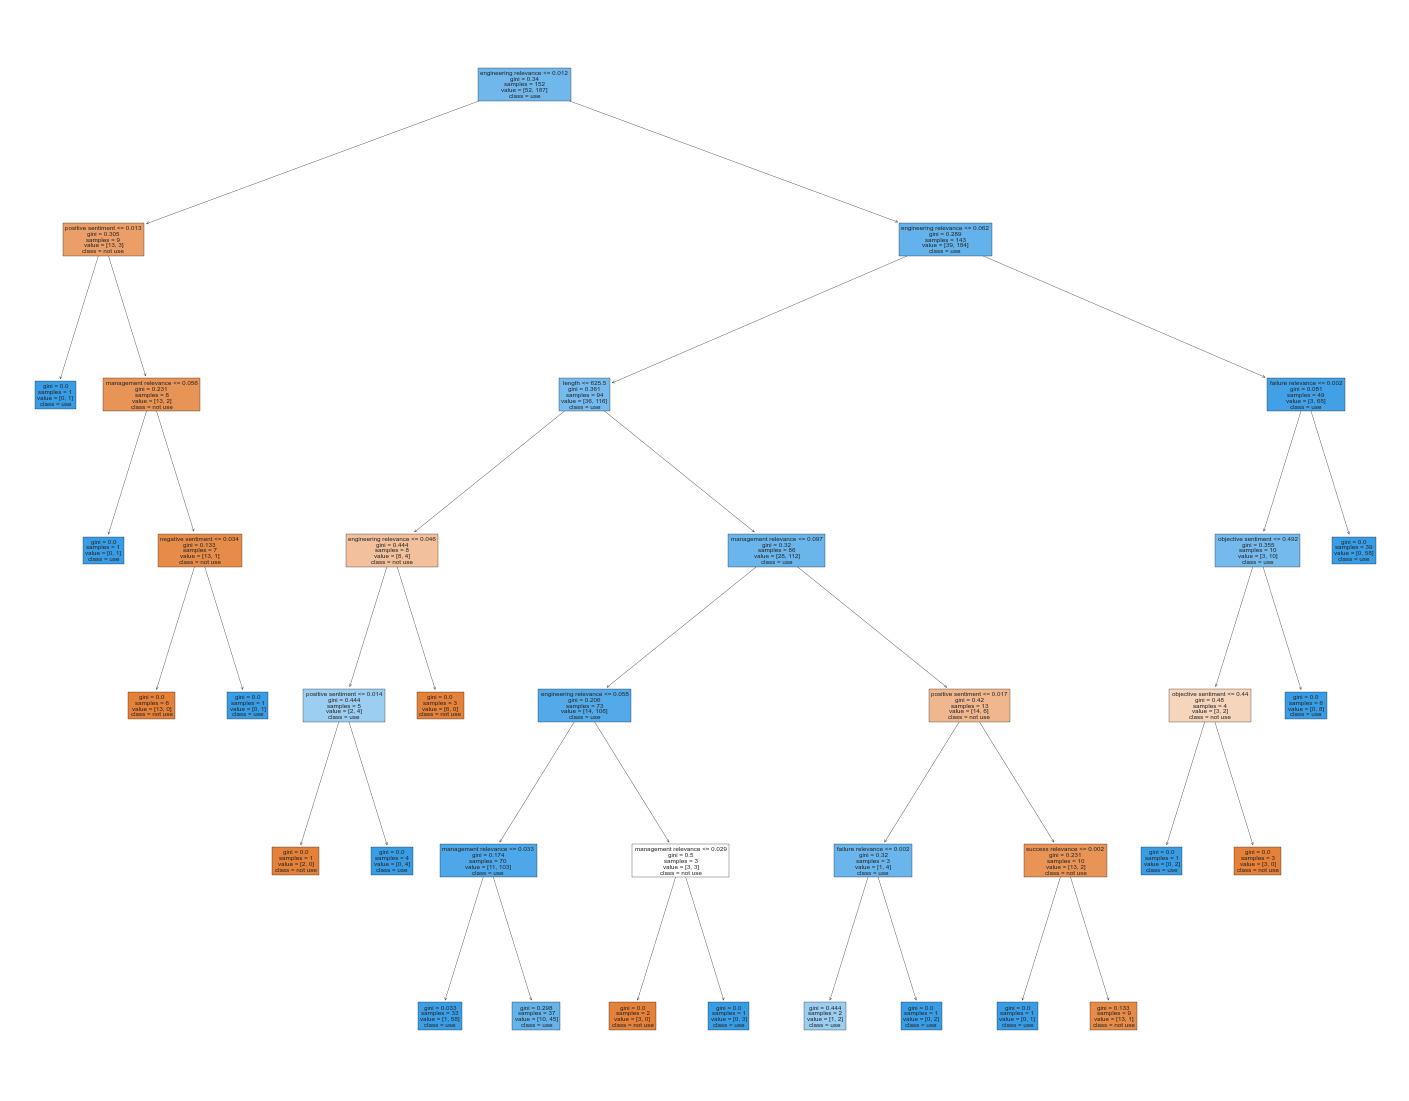

In [25]:
from sklearn import tree
import graphviz
i = 0
target_names = ['use', 'not use']
for tree_in_forest in model.estimators_:
    if i <2:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(tree_in_forest, feature_names=features, class_names=['not use', 'use'],filled=True)
        i+=1
        fig.show()
        #fig.savefig("decistion_tree.png")
        """
for tree_in_forest in model.estimators_:
    if i <2:
        fig = plt.figure(figsize=(25,20))
        _ = tree.plot_tree(tree_in_forest, feature_names=features,filled=True)
        i+=1
        fig.show()"""

In [26]:
from dtreeviz.trees import dtreeviz
from graphviz import dot# remember to load the package
import os
#os.environ['PATH'] += os.pathsep+"C:\Users\srandrad\graphviz-2.44.1-win32\Graphviz\bin"
X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use']
#tree_in_forest in model.estimators_
viz = dtreeviz(model.estimators_[4], X, y,
                target_name="target",
                feature_names=features,
                class_names=["use", "not use"])

viz
viz.save("adaboost_decision_tree.svg")

In [27]:
def learning_curves(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, X, y, train_sizes =train_sizes,
                                                                  cv = cv)#, scoring = 'neg_mean_squared_error')
    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)

    plt.plot(train_sizes, train_scores_mean, label = 'Training error')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
    #plt.ylim([0.75, 1])
    plt.ylabel('Score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    #plt.ylim(0,40)

In [ ]:
train_sizes = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]

plt.figure(figsize = (16,5))

plt.subplot()
learning_curves(model, df_test_set_with_scores[features], df_test_set_with_scores["use"].astype(int), train_sizes, 5)

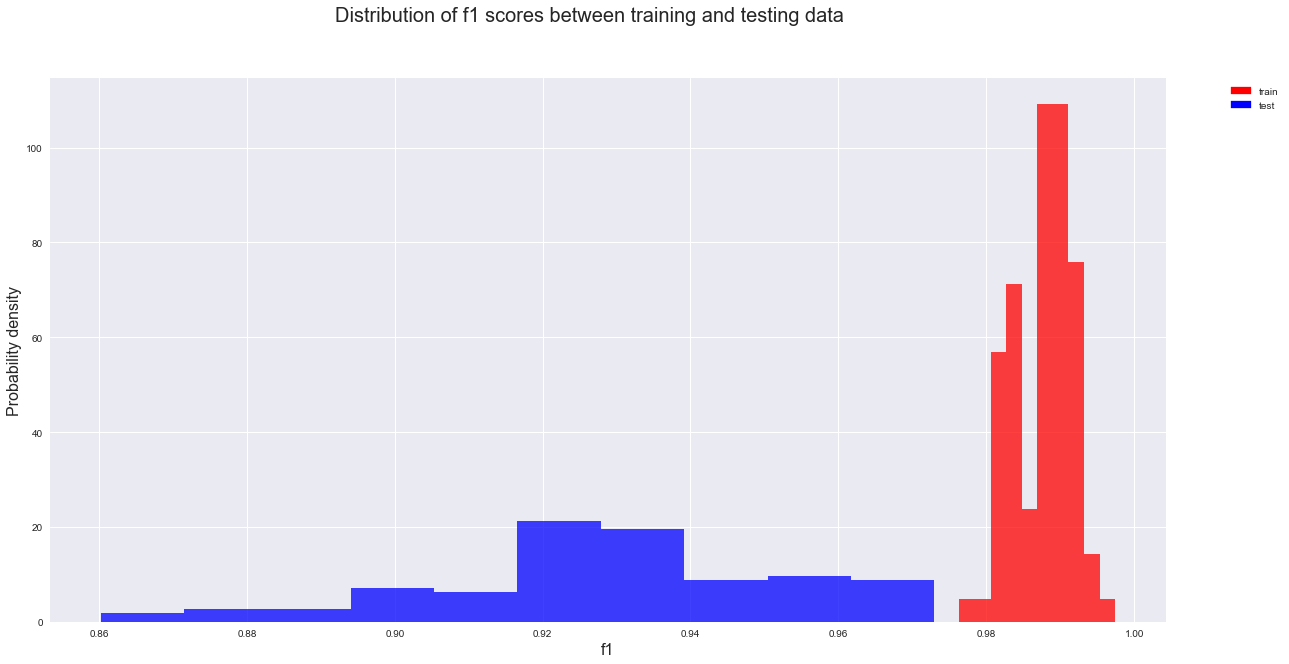

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,23.929893,99,two-sided,5.992418e-43,"[0.05, 0.06]",3.471647,3.447e+39,1.0


In [29]:
model = RandomForestClassifier(n_estimators=240,max_depth=6, random_state=0)
train_acc = []
test_acc = []
for i in range (0,100):
    X = df_test_set_with_scores[features]
    y = df_test_set_with_scores['use']
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
    model.fit(X_train.astype(float), y_train.astype(int)) #Training the model
    #conf_mat.append(confusion_matrix(y_test.astype(int),model.predict(X_test.astype(float))))
    train_acc.append(f1_score(y_train.astype(int), model.predict(X_train.astype(float))))
    test_acc.append(f1_score(y_test.astype(int), model.predict(X_test.astype(float))))

fig = plt.figure(figsize= (20, 10))
ax = fig.add_subplot(111)

p_d1= plt.hist(train_acc, label= "train",density= True, alpha=0.75, color = 'red')
p_d2 = plt.hist(test_acc, label= "test",density= True, alpha=0.75, color = 'blue')
title = 'Distribution of f1 scores between training and testing data' 
plt.suptitle(title, fontsize= 20)
plt.xlabel("f1", fontsize= 16)
plt.ylabel("Probability density", fontsize= 16)
label1 = patches.Patch(color = 'red', label = "train")
label2 = patches.Patch(color = 'blue', label = "test")
plt.legend(handles = [label1, label2], bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()
display(pg.ttest(train_acc, test_acc, paired = True))

C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\srandrad\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scor

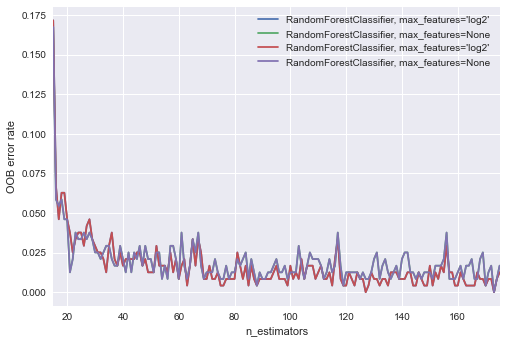

In [30]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 123


X = df_test_set_with_scores[features]
y = df_test_set_with_scores['use'].astype(int)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
test_error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        clf.predict(X_test)
        oob_error = 1 - clf.oob_score_
        test_error_rate[label].append((i, oob_error))
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
for label, clf_err in test_error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()